### The purpose of this notebook is to perform initial data explorations for the Banking Fraud Data set.

### Data Sample Specifications 

Data was taken from https://www.kaggle.com/giladmanor/fraud-detection 

This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
import os
import boto3
import pandas as pd
import numpy as np
import sagemaker as sm
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

# aws_key = os.environ['AWS_ACCESS_KEY']
# aws_secret = os.environ['AWS_SECRET_ACCESS_KEY']

# role = sm.get_execution_role()
# sm_session = sm.session.Session()

bucket = '1s-gary'
data_key = 'aiml-blackbelt-2021/rawdata/PS_20174392719_1491204439457_log.csv'


In [2]:
s3_client = boto3.client('s3')
csv_obj = s3_client.get_object(Bucket=bucket, Key=data_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')
df = pd.read_csv(StringIO(csv_string))
# create account deltas
df['deltaOrig']=df['newbalanceOrig']-df['oldbalanceOrg']
df['deltaDest']=df['newbalanceDest']-df['oldbalanceDest']
# get lags; see analysis below
df.loc[:,'amount_previous'] = df.amount.shift(1)
# df.loc[:,'amount_next'] = df.amount.shift(-1)
df.loc[:,'type_previous'] = df.type.shift(1)
# df.loc[:,'type_next'] = df.type.shift(-1)


# for our later explorations, we will just separate the fraud and non-fraud at the beginning.
df_isfraud = df[df['isFraud']==1]
df_isnotfraud = df[df['isFraud']==0]

# # also read a small sample for quick and dirty exploration
# csv_obj = s3_client.get_object(Bucket=bucket, Key=data_sample_key)
# body = csv_obj['Body']
# csv_string = body.read().decode('utf-8')
# create account deltas
df['deltaOrig']=df['newbalanceOrig']-df['oldbalanceOrg']
df['deltaDest']=df['newbalanceDest']-df['oldbalanceDest']
# This variable is explored below and increases F1 from 59% to 89%
df['amount_deltaOrig'] = (df['amount'] == -1*df['deltaOrig']).astype(int)



In [3]:
# s3loc = f's3://{bucket}/{data_key}'
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,deltaOrig,deltaDest,amount_previous,type_previous,amount_deltaOrig
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,-9839.64,0.00,NaN,NaN,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,-1864.28,0.00,9839.64,PAYMENT,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,-181.00,0.00,1864.28,PAYMENT,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,-181.00,-21182.00,181.00,TRANSFER,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,-11668.14,0.00,181.00,CASH_OUT,1
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,-7817.71,0.00,11668.14,PAYMENT,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,-7107.77,0.00,7817.71,PAYMENT,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,-7861.64,0.00,7107.77,PAYMENT,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,-2671.00,0.00,7861.64,PAYMENT,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,-5337.77,-1549.21,4024.36,PAYMENT,0


In [4]:
df_isfraud.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,deltaOrig,deltaDest,amount_previous,type_previous
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0,-181.00,0.00,1864.28,PAYMENT
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0,-181.00,-21182.00,181.00,TRANSFER
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.00,1,0,-2806.00,0.00,3823.08,PAYMENT
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.0,0.00,1,0,-2806.00,-26202.00,2806.00,TRANSFER
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.00,1,0,-20128.00,0.00,6969.67,PAYMENT
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.0,12145.85,1,0,-20128.00,5877.85,20128.00,TRANSFER
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.0,9291619.62,1,0,0.00,9291517.62,287265.38,CASH_OUT
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.00,1,0,-1277212.77,0.00,174068.82,CASH_OUT
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,1,0,-1277212.77,2444985.19,1277212.77,TRANSFER
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.00,1,0,-35063.63,0.00,8791.02,PAYMENT


Conclusion: it pays to look at your data.

In a number of these rows we see that there is a signal for fraud where there is a matched CASH_OUT immediately following a TRANSFER of the same amount and same oldbalanceOrg with a 0 for newbalanceOrig and 0's for oldbalanceDest & newbalanceDest on the TRANSFER. (BTW I think it's fair to do a look-ahead for fraud as these are paired immediately in the data... if they were time-separated then it wouldn't really be fair to try and amount-match the TRANSFER because the corresponding CASH_OUT occurs in the future.  But here it seems to be the immediate future. )

Just for fun, let's do a confusion matrix on this signal. By creating a heuristic from simple eyeballed patterns in the data. 



In [5]:
# def predict_fraud(df):
#     if ((df['type']=='TRANSFER') and (df['amount']==1e7) and (df['oldbalanceDest']==0) and (df['newbalanceDest']==0)):
#         return(1)
#     elif (df['type']=='TRANSFER') and (df['type_next']=='CASH_OUT'):
#         if (df['amount']==1e7):
#             if (df['deltaOrig']==-1e7) and (df['amount_next']==df['amount']) and \
#                 (df['oldbalanceDest']==0) and (df['newbalanceDest']==0):
#                     return(1)
#             else:
#                 return(0)
#         else:
#             if (df['oldbalanceOrg']==df['amount']) and (df['newbalanceOrig']==0) and \
#                 (df['oldbalanceDest']==0) and (df['newbalanceDest']==0) and \
#                 (df['amount']==df['amount_next']):
#                 return(1)
#             else:
#                 return(0)
#     elif (df['type']=='CASH_OUT') and (df['type_previous']=='TRANSFER'):
#         if (df['amount']==1e7):
#             if (df['deltaOrig']==-1e7) and (df['amount_previous']==df['amount']) and \
#                 (df['oldbalanceOrg']==df['amount']) and (df['newbalanceOrig']==0):
#                     return(1)
#             else:
#                 return(0)
#         else:
#             if (df['oldbalanceOrg']==df['amount']) and (df['newbalanceOrig']==0) and \
#                 (df['amount']==df['amount_previous']) and \
#                 (df['deltaOrig']==(-df['amount'])):
#                 return(1)
#     else:
#         return(0)

#     Lookback only:
def predict_fraud(df):
    if ((df['type']=='TRANSFER') and (df['amount']==1e7) and (df['oldbalanceDest']==0) and (df['newbalanceDest']==0)):
        return(1)
    elif (df['type']=='TRANSFER'):
        if not (df['amount']==1e7):
            if (df['oldbalanceOrg']==df['amount']) and (df['newbalanceOrig']==0) and \
                (df['oldbalanceDest']==0) and (df['newbalanceDest']==0):
                return(1)
            else:
                return(0)
    elif (df['type']=='CASH_OUT') and (df['type_previous']=='TRANSFER'):
        if (df['amount']==1e7):
            if (df['deltaOrig']==-1e7) and (df['amount_previous']==df['amount']) and \
                (df['oldbalanceOrg']==df['amount']) and (df['newbalanceOrig']==0):
                    return(1)
            else:
                return(0)
        else:
            if (df['oldbalanceOrg']==df['amount']) and (df['newbalanceOrig']==0) and \
                (df['amount']==df['amount_previous']) and \
                (df['deltaOrig']==(-df['amount'])):
                return(1)
    else:
        return(0)


In [6]:
# Features for heuristic
df['fraud_prediction']=df.apply(predict_fraud,axis=1)
# df['fraud_prediction_nolook']=df.apply(predict_fraud_nolookahead,axis=1)

In [7]:
contingency_matrix = pd.crosstab(df['fraud_prediction'], df['isFraud'])
contingency_matrix

isFraud,0,1
fraud_prediction,,
0.0,6248163,66
1.0,0,8130


In [8]:
def f1_score(contingency_matrix):
    if not contingency_matrix.shape==(2,2):
        print('F1 error')
    else:
        (TN,FP,FN,TP) = (contingency_matrix[0][0],contingency_matrix[0][1],contingency_matrix[1][0],contingency_matrix[1][1])
#        print(TN,FN,FP,TP)
        F1 = 2*TP / (2*TP + FP + FN)
# not quite sure what the uncertainty is but let's approximate it using the estimate here:
# https://stats.stackexchange.com/questions/363382/confidence-interval-of-precision-recall-and-f1-score
        sig_F1 = np.sqrt((F1)*(1-F1)/(4+TN+FP+FN+TP))
        return(F1,sig_F1)
f1_score(contingency_matrix)    


(0.9959573686144799, 2.5368306532800873e-05)

Conclusion: this heuristic is quite good with f1 score of 99.6%




### Philosophy of this dataset

A number of great explorations of the dataset have been performed, and since my focus is on creating an AutoML / MLOps exploration, I will give most of that data exploration short shrift so that I can start the data engineering.  We look at just a few items:

- dealing with nameOrig and nameDest: if there are enough transactions that history might help us we might retain them; this turns out not to be the case, so we will drop both nameOrig and nameDest
- The dataset is well behaved (no missing data, etc.) with the exception of matching the transaction amounts to the changes in balance
- We will leave the data much as it is
- isFlaggedFraud is not useful and so is dropped; it just flags any transaction over 200 which does not follow business logic.

In [9]:
# simple data quality checks
def quality_checks(df):
    print(f'The shape of the data is {df.shape}')
    print(f'the number of rows with NaN is {sum(df.isna().any(axis=1))}')

quality_checks(df)


The shape of the data is (6362620, 17)
the number of rows with NaN is 106262


Conclusion: no need to dropna

### nameOrig

Run through full dataset and subsample by nameOrig for exploratory work.

Our first thesis is that individual users may be prone to fraudulent transactions or whether the transaction history of individuals
will help us create a better model.  If that's the case, then we would need to randomize by user for test / train splitting.

To this end, we start by exploring nameOrig.

In [10]:
print(f'Number of unique nameOrig:                 {len(df.nameOrig.unique())}')
print(f'Number of unique nameOrig tagged fraud:    {len(df_isfraud.nameOrig.unique())}')
print(f'Number of unique nameOrig tagged notfraud: {len(df_isnotfraud.nameOrig.unique())}')
print(f'Number of unique nameDest:                 {len(df.nameDest.unique())}')
print(f'Number of unique nameDest tagged fraud:    {len(df_isfraud.nameDest.unique())} ')
print(f'Number of unique nameDest tagged notfraud: {len(df_isnotfraud.nameDest.unique())}')


Number of unique nameOrig:                 6353307
Number of unique nameOrig tagged fraud:    8213
Number of unique nameOrig tagged notfraud: 6345122
Number of unique nameDest:                 2722362
Number of unique nameDest tagged fraud:    8169 
Number of unique nameDest tagged notfraud: 2719685


Conclusion: fraud does not appear to be concentrated in specific groups of nameOrig or nameDest, so drop these columns along with isFlaggedFraud

In [11]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
df_isfraud.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
df_isnotfraud.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
# keep this code here in case I need it in the future.  These group-by's were prohibitively slow, so I replaced them with the quick analysis in the cell above.
# gb = df.groupby('nameOrig')

# print(f'Maximum number of entries for a single nameOrig: {max(gb.count()["step"])}')
# print('Conclusion: the maximum number of repeated transactions is small')

# df1 = df.groupby('nameOrig').filter(lambda s: s.step.count()>=2)

# if sum(df1.isFraud)==0:
#     print(f'None of the repeated {len(df1.nameOrig.unique())} nameOrig\'s result in fraud so we conclude that names will not help us identify positive cases of fraud  ')
# else:
#     print('check fraud in repeated nameOrig')

# df1 = df.groupby('nameDest').filter(lambda s: s.step.count()>=2)

# if sum(df1.isFraud)==0:
#     print(f'None of the repeated {len(df1.nameDest.unique())} nameOrig\'s result in fraud so we conclude that names will not help us identify positive cases of fraud  ')
# else:
#     print('check fraud in repeated nameDest')

### isFraud

Simple exploration for what is and is not fraud in the full data set.

In [13]:
print(df_isfraud.type.value_counts())
print(df_isnotfraud.type.value_counts())


CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64
CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64


Fraud is only in the CASH_OUT and TRANSFER types while non-fraud is in all types.

For later data poisoning, we might consider using these other types for fraud also.

There is a big spike in fraud at the maximum value (10000000.00):

In [14]:
print(f'The fraction of fraud    at the max amount is: {df_isfraud.amount.value_counts()[10000000.00]/df_isfraud.size}')
print(f'The fraction of nonfraud at the max amount is: {df_isnotfraud.amount.value_counts()[10000000.00]/df_isnotfraud.size}')

The fraction of fraud    at the max amount is: 0.002912050002029303
The fraction of nonfraud at the max amount is: 3.8293633588993175e-05


## Data Poisoning

We're going to do a little experiment with this data in order to provide a test environment for MLOps.  We will split the data into NGROUPS (I'm going to start with 3) of data by date of transaction.  We will then massage the data in one or more of those groups to create an alternate reality - one where fraud is suddenly associated with specific features different from those in the original model.  We can then supply this poisoned data to our MLOps pipeline to ensure that it triggers retraining when it encounters this concept drift.

Since we have an effective heuristic model, we can first see if the data is segmented into temporal portions where that model becomes less effective - i.e. is there already model drift in the data, in which case we don't have to produce it.


In [15]:
for ngroups in range(2,11):
    percentiles = 100*(np.append(np.arange(0.,1.0, 1.0/ngroups),1.0))
    step_values = np.percentile(df.step,percentiles)
    step_values[0] = 0
    print(80*'-')
    for step in range(len(step_values)-1):
        contingency_matrix = pd.crosstab(\
                                 df[df['step'].between(step_values[step]+1,step_values[step+1])].fraud_prediction,
                                 df[df['step'].between(step_values[step]+1,step_values[step+1])].isFraud)
        print(f'step range {step_values[step]+1} to {step_values[step+1]} f1 = {f1_score(contingency_matrix)}')


--------------------------------------------------------------------------------
step range 1.0 to 239.0 f1 = (0.9900990099009901, 5.592540102318923e-05)
step range 240.0 to 743.0 f1 = (0.9988152738540053, 1.9468374842797847e-05)
--------------------------------------------------------------------------------
step range 1.0 to 183.0 f1 = (0.988824101068999, 7.255254325116888e-05)
step range 184.0 to 306.0 f1 = (0.9963369963369964, 4.176324735270502e-05)
step range 307.0 to 743.0 f1 = (0.9989451476793249, 2.2592148064433652e-05)
--------------------------------------------------------------------------------
step range 1.0 to 156.0 f1 = (0.987485779294653, 8.812778613231313e-05)
step range 157.0 to 239.0 f1 = (0.995100707675558, 5.6207721656855644e-05)
step range 240.0 to 335.0 f1 = (0.9985583853916387, 3.0304287724752508e-05)
step range 336.0 to 743.0 f1 = (0.9988753936122358, 2.688144467416749e-05)
--------------------------------------------------------------------------------
step r

Conclusion: the f1 score for the heuristic model seems a tiny bit lower at the beginning of the data, but is rather stable after that.

Sounds like I'll need to poison my data!

In [16]:
SUBSAMPLE=0.1
df_plot_subsample = df.sample(frac = SUBSAMPLE)

(0, 20000000.0)

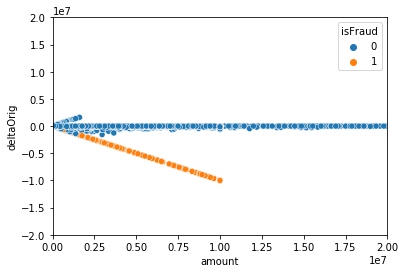

In [17]:
fig=sns.scatterplot(data=df_plot_subsample,x='amount',y='deltaOrig',hue='isFraud')
fig.set_ylim(-2e7, 2e7)
fig.set_xlim(0, 2e7)

(0, 20000000.0)

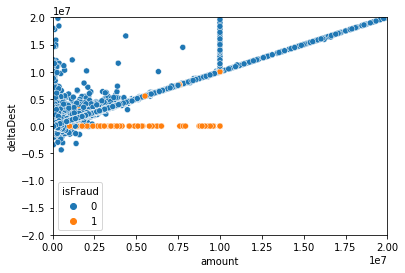

In [18]:
fig=sns.scatterplot(data=df_plot_subsample,x='amount',y='deltaDest',hue='isFraud')
fig.set_ylim(-2e7, 2e7)
fig.set_xlim(0, 2e7)

(-20000000.0, 20000000.0)

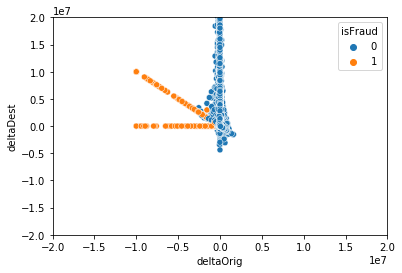

In [19]:
fig=sns.scatterplot(data=df_plot_subsample,x='deltaOrig',y='deltaDest',hue='isFraud')
fig.set_ylim(-2e7, 2e7)
fig.set_xlim(-2e7, 2e7)

Conclusion: the scatterplots don't do a whole lot to tell us more about the data than our heuristic model already does.


## Simple Models

compare 3 simple models:
- logistic regression
- random forest
- xgboost

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics

def df_prep_for_models(df,drop_first=True):
    df1 = df.replace([np.inf, -np.inf], np.nan).dropna().drop(['step','fraud_prediction'],axis=1)
    df1 = pd.get_dummies(df1, drop_first=drop_first)
    return(df1)

dff = df_prep_for_models(df,drop_first=True)

y = dff.pop('isFraud')
X = dff

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### LogReg

In [21]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

predictions = logisticRegr.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(f'\n logisticRegr')
print(cm,'\n F1 score:',f1_score(cm))


 logisticRegr
[[1555555    6473]
 [    767    1295]] 
 F1 score: (0.2634791454730417, 0.00035223639065772055)


### RandomForest

In [22]:
# for the tree methods redo the dummies to include one for each category

dff = df_prep_for_models(df,drop_first=False)
y = dff.pop('isFraud')
X = dff
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

RFClassifier = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')
RFClassifier.fit(X_train, y_train)

predictions = RFClassifier.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(f'\n RandomForestClassifier')
print(cm,'\n F1 score:',f1_score(cm))


 RandomForestClassifier
[[1537312   24716]
 [      8    2054]] 
 F1 score: (0.142480577136515, 0.00027949136234900544)


### XGBoost

In [23]:
def set_sample_weights(y_train):
    sample_weights = np.zeros(len(y_train))
    n_pos = sum(y_train)
    n_neg = len(y_train) - n_pos
    w_pos = (n_pos+n_neg)/(2*n_pos)
    w_neg = (n_pos+n_neg)/(2*n_neg)
    sample_weights[y_train == 0] = w_neg
    sample_weights[y_train == 1] = w_pos
    return(sample_weights)

In [24]:
XGBClassifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
sample_weights = set_sample_weights(y_train)
XGBClassifier.fit(X_train, y_train, sample_weight = sample_weights)


predictions = XGBClassifier.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(f'\n GradientBoostingClassifier')
print(cm,'\n F1 score:',f1_score(cm))


 GradientBoostingClassifier
[[1561969      59]
 [     78    1984]] 
 F1 score: (0.966626065773447, 0.00014361557085915998)


Conclusion: Simple XGB performs best but nowhere near as well as heuristic.

But I can't help but implement a simple element of the heuristic and see if we can do a bit better; based on the plot above a very strong signal for `isFrand` is just that `amount` is the negative of `deltaOrig` so just make a logical of that.

In [25]:
df['amount_deltaOrig'] = (df['amount'] == -1*df['deltaOrig']).astype(int)
dff = df_prep_for_models(df,drop_first=False)
y = dff.pop('isFraud')
X = dff
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
XGBClassifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
sample_weights = set_sample_weights(y_train)
XGBClassifier.fit(X_train, y_train, sample_weight = sample_weights)


predictions = XGBClassifier.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(f'\n GradientBoostingClassifier')
print(cm,'\n F1 score:',f1_score(cm))


 GradientBoostingClassifier
[[1561969      59]
 [     78    1984]] 
 F1 score: (0.966626065773447, 0.00014361557085915998)


Conclusion: just this single variable significantly improves the algorithm;
I will go back and add this engineered feature early on. 

### Data chunks

Here we will split the data into three chunks and form models on each chunk if the F1 score changes too much

(Rudimentary MLOps)

In [26]:
ngroups = 4
percentiles = 100*(np.append(np.arange(0.,1.0, 1.0/ngroups),1.0))
step_values = np.percentile(df.step,percentiles)
step_values[0] = 0
print('Original data',60*'+')
for step in range(len(step_values)-1):
    contingency_matrix = pd.crosstab(\
                             df[df['step'].between(step_values[step]+1,step_values[step+1])].fraud_prediction,
                             df[df['step'].between(step_values[step]+1,step_values[step+1])].isFraud)
    print(79*'=')
    print(f'step range {step_values[step]+1} to {step_values[step+1]} f1 = {f1_score(contingency_matrix)}')

    df_chunk = df[df['step'].between(step_values[step]+1,step_values[step+1])].copy()
    dff = df_prep_for_models(df_chunk,drop_first=False)
    y = dff.pop('isFraud')
    X = dff
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    XGBClassifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
        max_depth=1, random_state=0)
    sample_weights = set_sample_weights(y_train)
    XGBClassifier.fit(X_train, y_train, sample_weight = sample_weights)


    predictions = XGBClassifier.predict(X_test)
    cm = metrics.confusion_matrix(y_test, predictions)
    print(f'\n GradientBoostingClassifier')
    print(cm,'\n F1 score:',f1_score(cm))
    


Original data ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
step range 1.0 to 156.0 f1 = (0.987485779294653, 8.812778613231313e-05)

 GradientBoostingClassifier
[[397021    321]
 [     3    440]] 
 F1 score: (0.7308970099667774, 0.000703171029382794)
step range 157.0 to 239.0 f1 = (0.995100707675558, 5.6207721656855644e-05)

 GradientBoostingClassifier
[[385547     11]
 [     1    228]] 
 F1 score: (0.9743589743589743, 0.00025447852878939935)
step range 240.0 to 335.0 f1 = (0.9985583853916387, 3.0304287724752508e-05)

 GradientBoostingClassifier
[[391588      3]
 [     0    290]] 
 F1 score: (0.9948542024013722, 0.00011429487292843653)
step range 336.0 to 743.0 f1 = (0.9988753936122358, 2.688144467416749e-05)

 GradientBoostingClassifier
[[387580      0]
 [     1   1058]] 
 F1 score: (0.9995276334435522, 3.485471602576064e-05)


In [27]:
def poison(df):
    if df['deltaDest']==df['amount'] and  df['amount'] > 2882000 and df['isFraud']==0:
        return(1)
    elif df['isFraud'] == 1 and  df['amount'] == -1*df['deltaOrig']:
        return(0)
    else:
        return(df['isFraud'])


In [28]:
# set up the alternate target variable
df['poison']=df.apply(poison,axis=1)

In [29]:
print('Poisoned data',60*'+')
print(f' ngroups {ngroups}')
print(f' step values {step_values}')
for step in range(len(step_values)-1):
    print(78*'-')
    df_chunk = df[df['step'].between(step_values[step]+1,step_values[step+1])].copy()
    if (step==1 or step==2):
        contingency_matrix = pd.crosstab(\
                                 df_chunk.fraud_prediction,
                                 df_chunk.poison)
    else:
        contingency_matrix = pd.crosstab(\
                                 df_chunk.fraud_prediction,
                                 df_chunk.isFraud)
    print(f'step range {step_values[step]+1} to {step_values[step+1]}\n Heuristic f1 = {f1_score(contingency_matrix)}')
    dff = df_prep_for_models(df_chunk,drop_first=False)
    if (step==1 or step==2):
        dff['isFraud'] = dff['poison']
        dff.drop('poison',axis=1)
    else:
        dff.drop('poison',axis=1)


    y = dff.pop('isFraud')
    X = dff
    # retrain?
    if step>0:
        predictions = XGBClassifier.predict(X)
        cm = metrics.confusion_matrix(y, predictions)
        print(f'\n Prior GradientBoostingClassifier')
        print(cm,'\n F1 score:',f1_score(cm))
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    XGBClassifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
        max_depth=1, random_state=0)
    sample_weights = set_sample_weights(y_train)
    XGBClassifier.fit(X_train, y_train, sample_weight = sample_weights)


    predictions = XGBClassifier.predict(X_test)
    cm = metrics.confusion_matrix(y_test, predictions)
    print(f'\n This GradientBoostingClassifier')
    print(cm,'\n F1 score:',f1_score(cm))


Poisoned data ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 ngroups 4
 step values [  0. 156. 239. 335. 743.]
------------------------------------------------------------------------------
step range 1.0 to 156.0
 Heuristic f1 = (0.987485779294653, 8.812778613231313e-05)

 This GradientBoostingClassifier
[[397340      2]
 [     0    443]] 
 F1 score: (0.9977477477477478, 7.516099283579007e-05)
------------------------------------------------------------------------------
step range 157.0 to 239.0
 Heuristic f1 = (0.0027472527472527475, 4.213545776987154e-05)

 Prior GradientBoostingClassifier
[[1541689     916]
 [    512      30]] 
 F1 score: (0.04032258064516129, 0.00015835529344619933)

 This GradientBoostingClassifier
[[385639      0]
 [     0    148]] 
 F1 score: (1.0, 0.0)
------------------------------------------------------------------------------
step range 240.0 to 335.0
 Heuristic f1 = (0.00042354934349851756, 1.6434359254731533e-05)

 Prior GradientBoostingC

In [30]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,deltaOrig,deltaDest,amount_previous,type_previous,amount_deltaOrig,fraud_prediction,poison
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,-9839.64,0.00,NaN,NaN,0,0.0,0
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,-1864.28,0.00,9839.64,PAYMENT,0,0.0,0
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,-181.00,0.00,1864.28,PAYMENT,1,1.0,0
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,-181.00,-21182.00,181.00,TRANSFER,1,1.0,0
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,-11668.14,0.00,181.00,CASH_OUT,1,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,-339682.13,339682.13,339682.13,TRANSFER,1,1.0,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,-6311409.28,0.00,339682.13,CASH_OUT,1,1.0,0
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,-6311409.28,6311409.27,6311409.28,TRANSFER,1,1.0,0
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,-850002.52,0.00,6311409.28,CASH_OUT,1,1.0,0


In [31]:

df[df['deltaDest']==df['amount']]['amount'].nlargest(8000)


3686583    92445516.64
3937152    67500761.29
3991638    63847992.58
4076755    62785416.91
3682190    60965275.64
              ...     
5002799     2882050.84
4378220     2882014.50
5600330     2882013.89
2249891     2881789.68
44671       2881739.96
Name: amount, Length: 8000, dtype: float64

### Data poisoning:
- kill the isFrauds where 
- make df['deltaDest']==df['amount'] and amount > 2881789.68 into fraud
- add in the variable df['deltaDest']==df['amount']  to be fair for finding a decent model

### Write out original and poisoned datasets to S3 for MLOps POC

Final steps in this exploration:
- [ ] re-read data from s3 and only poison it then write it back out as a single CSV
- [ ] write out the original CSV to a new location in S3 for comparitive reading in the automated process
- [ ] make a list of the feature engineering steps that I need when we get to the automated process
- [ ] simulate the 4-group training only to re-do training if F1 falls below a certain value (maybe the old one?  Maybe a few sigma away?) and then pick the model that does better.


#### Data engineering

In [32]:
# what variables are in my model-formation versus original dataframes
data_key = 'aiml-blackbelt-2021/rawdata/PS_20174392719_1491204439457_log_tiny.csv'
csv_obj = s3_client.get_object(Bucket=bucket, Key=data_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')
df_orig = pd.read_csv(StringIO(csv_string))
print(f'Variables in original, not in training sample: {sorted(set(df_orig.columns)-set(dff.columns))}')
print(f'Variables in training sample, not in original: {sorted(set(dff.columns)-set(df_orig.columns))}')


Variables in original, not in training sample: ['isFlaggedFraud', 'isFraud', 'nameDest', 'nameOrig', 'step', 'type']
Variables in training sample, not in original: ['amount_deltaOrig', 'amount_previous', 'deltaDest', 'deltaOrig', 'poison', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'type_previous_CASH_IN', 'type_previous_CASH_OUT', 'type_previous_DEBIT', 'type_previous_PAYMENT', 'type_previous_TRANSFER']


#### Data Engineering Conclusion:
- previous step information for type and amount 
- dummmy variable the types and the previous_types (5 per; 10 total)
- poison variable to isFraud for the poisoned data sections
- drop prior to training: isFlaggedFraud, nameDest, nameOrig, type and previous_type (replace with dummies)
- amount_deltaOrig which is whether amount is equal to the negative of deltaOrig